# CONTEXTE
* Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

* Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

* Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

* Pour réaliser ce modèle, Michaël, votre manager, vous a fourni le jeu de données suivant qui contient :

    - un historique de prêts ;
    - un historique d’informations financières ;
    - des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut ou pas). 

* Après une première réunion de brief, Michaël vous a envoyé ce mail de récap :

De : Michaël / Envoyé : hier 17:14 / À : Vous 

Objet : Récap. Algo de scoring

Hello,

Merci pour notre meeting. Je souhaitais le compléter en te donnant quelques ressources :

- Pour aller plus vite sur la préparation des données, tu peux utiliser un **kernel Kaggle** (https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook). Par contre, fais attention à ce qu’il soit adapté à ton besoin. 
- Essaie notamment de **construire au moins trois nouvelles variables à partir des variables existantes** qui te semblent pertinentes pour améliorer le pouvoir prédictif du modèle. Essaie aussi de t’approprier le kernel au maximum en l’adaptant pour le projet.
- On a évoqué le fait que ton modèle doit être interprétable par les équipes qui vont l’utiliser. N’hésite pas à consulter ce site (https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f) et ce GitHub (https://christophm.github.io/interpretable-ml-book/) à ce sujet. 
- Pense à **expliciter en quelques lignes la méthode d’importance des variables que tu retiendras**. Je souhaite une **analyse de l’importance des variables globale au modèle [le modèle que j'aurais dev], mais également locale pour un client donné [la même analyse pour un exemple client dans le dataset]**.
- Le modèle sera à présenter aux équipes, fais donc en sorte que ta présentation soit compréhensible par tous, et que ton Jupyter soit bien documenté. 
- **Pour les slides, je te suggère ce plan** :
    * Compréhension de la problématique métier.
    * Description du jeu de données.
    * Transformation du jeu de données (nettoyage et feature engineering).
    * Comparaison et synthèse des résultats pour les modèles utilisés.
    * Interprétabilité du modèle.
    * Conclusion.
        

* Concernant l’élaboration du modèle soit vigilant sur deux points spécifiques au contexte métier : 

    - Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix
    - Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
    - Tu pourras supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
    - Tu créeras un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.
    - **Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)**
    
**[ l'idée : rajouter en métrique d'évaluation des modèles, une fonction qui calcule le cout pour un FN et pour un FP, et l'utiliser pour sélectionner le meilleur modèle]**

En parallèle, maintiens pour comparaison et contrôle, des mesures plus techniques, telles que **l’AUC et l’accuracy**. 

D’autre part je souhaite que tu mettes en œuvre une démarche d’élaboration des modèles avec **Cross-Validation et optimisation des hyperparamètres, via GridsearchCV ou équivalent**.

Un dernier conseil : si tu obtiens des scores supérieurs au 1er du challenge Kaggle (AUC > 0.82), pose-toi la question si tu n’as pas de l’overfitting dans ton modèle !

Bon courage !

Michaël

Muni de toutes ces informations, vous vous mettez au travail ! 

# LIVRABLES

* Un Jupyter Notebook d'analyse exploratoire et de feature engineering
* Un Jupyter Notebook présentant les différentes parties de votre travail de modélisation :
    - Ces notebooks doivent pouvoir être utilisés par une autre personne, comme Michaël, par exemple. Leur présentation et leur structuration doivent donc être soignées afin que les notebooks puissent être pris en main par une personne autre que vous, sans que vous ayez à la former à leur utilisation.
* Une présentation (PowerPoint ou une alternative, sauvegardé au format pdf) :
    - Ce livrable vous servira à présenter votre approche méthodologique de modélisation de la problématique de scoring lors de la soutenance orale devant Michaël.

# IMPORTS

In [2]:
# data & science
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import *
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
# graphiques
import matplotlib.pyplot as plt
import seaborn as sns
# system & tools
import pickle
import os
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
#import sys
#sys.path.insert(0, '/Users/stephanieduhem/Documents/MASTER_AI_ENGINEER/openclassroom/tools')
#import functions as fct




print(imblearn.__version__)

0.12.0


# FONCTIONS

In [21]:
##### FONCTION POUR GÉNÉRER UN DF RÉCAPITULATIF DES NAN DANS CHAQUE COLONNE
def taux_nan(dataframe) :
    # RÉCUPÉRER LE NOMBRE TOTAL DE DONNÉES
    total_data = dataframe.size
    # RÉCUPÉRER LE NOMBRE TOTAL DE VALEURS MANQUANTES
    total_nan = dataframe.isna().sum().sum()
    # CALCULER LE POURCENTAGE TOTAL DE VALEURS MANQUANTES
    taux_nan = (total_nan / total_data) * 100
    print(f'Le dataframe sélectionné contient {round(taux_nan, 2)} % de valeurs manquantes')
    

##### FONCTION POUR GÉNÉRER UN DF RÉCAPITULATIF DES NAN DANS CHAQUE COLONNE
def recap_nan(dataframe) :
    
    # RÉCUPÉRER LE DÉCOMPTE DE NAN 
    recap_nan = {}
    list_50_percent = []
    list_0_nan = []
    for column in dataframe.columns :
        if dataframe[column].isnull().sum() == 0 :
                    list_0_nan.append(column)
        if dataframe[column].isnull().sum() != 0 :
            recap_nan[column] = dataframe[column].isnull().sum()
            if dataframe[column].isnull().sum() >= (len(dataframe)/2) :
                list_50_percent.append(column)
    
    if len(list_0_nan) == len(dataframe.columns)  :
        print ("Le dataframe sélectionné a " + str(dataframe.shape[1]) + " colonnes et " + str(dataframe.shape[0]) + " lignes.\n" 
           "* Il n'y a aucune colonne contenant des valeurs manquantes.")
    else :
        # VISUALISATION DANS UN DATAFRAME
        df_recap_nan = pd.DataFrame.from_dict(recap_nan, orient = 'index' )
        df_recap_nan = df_recap_nan.rename(columns={0:'decompte_NaN'})
        df_recap_nan['Taux_valeur_manquantes_%'] = (df_recap_nan['decompte_NaN'] / len(dataframe) * 100)
        df_recap_nan = df_recap_nan.sort_values('Taux_valeur_manquantes_%', ascending=True).reset_index()
        df_recap_nan = df_recap_nan.rename(columns={'index' : 'col_names'})
        
        print ("Le dataframe sélectionné a " + str(dataframe.shape[1]) + " colonnes et " + str(dataframe.shape[0]) + " lignes.\n" 
            "* Il y a " + str(len(list_0_nan)) + " colonnes sans aucune valeur manquante.\n"     
                "* Il y a " + str(df_recap_nan.shape[0]) + " colonnes avec des valeurs manquantes.\n"
                "* Parmi ces " + str(df_recap_nan.shape[0]) + " colonnes, il y a " + str(len(list_50_percent)) + " colonnes avec au moins 50% de valeurs manquantes.")
        return df_recap_nan


##### FONCTION GRAPHIQUE BASÉE SUR RECAP_NAN
def graph_nan(dataframe) :
    
    font= {'color':  'black', 'weight': 'bold', 'size': 20 }
    fig = plt.figure(figsize=(20, 28))
    sns.barplot(x="Taux_valeur_manquantes_%", y="col_names", data=dataframe, palette="crest")
    #Seuil 50% de taux de remplissage
    plt.axvline(x=50, linewidth=2, color = 'r')
    plt.axvline(x=100, linewidth=2, color = 'r')
    plt.text(50+2, 5, "Seuil 50% de taux de valeurs manquantes", fontdict= font)
    plt.title("Taux de valeurs manquantes des variables (%)", fontdict=font)
    plt.show()


# CHARGEMENT DES DONNÉES

In [3]:
# VISUALISATION DU CONTENU DU DOSSIER CONTENANT LES DATA
print(os.listdir("./input/"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


## DATA TRAIN


In [4]:
# TRAIN DATA
app_train = pd.read_csv('./input/application_train.csv')
print(app_train.info())
app_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# DESCRIPTION DES COLONNES
describ_col = pd.read_csv('./input/HomeCredit_columns_description.csv', sep=';', encoding='latin1')
describ_col[',Table,Row,Description,Special'].values

array(['1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,',
       '2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",',
       '5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,',
       '6,application_{train|test}.csv,CODE_GENDER,Gender of the client,',
       '7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,',
       '8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,',
       '9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,',
       '10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,',
       '11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,',
       '12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,',
      

* """2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 
0 - all other cases)","""
* pour la colonne TARGET :
    - le '1' correspond à un "mauvais" client (il a plus de X jours de retard de paiement sur au moins une des premières tranches Y du prêt qu'on lu a consenti)
    - le 'O' indique tous les autres cas, sous-entendu pour lesquels le métier considère qu'il s'agit d'un "bon" client (pas de retard de paiement, des retards de paiement plus tardifs etc..)


* Dans le jeu de données d'entraînement, nous avons 307511 observations et 122 variables.
* Chaque observation correspond à un crédit accordé. 
* Parmi les variables se trouve la target, qui signifie si l'emprunteur est considéré comme un "bon" client (0), ou un "mauvais" client (1).



## DATA TEST

In [6]:
# Testing data features
app_test = pd.read_csv('./input/application_test.csv')
print(app_test.info())
app_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


* Dans le jeu de données de test fourni, nous avons 48744 observations et 121 variables.
* La colonne TARGET est absente. De ce fait, nous n'utiliserons pas pour nos futurs travaux cet partie du jeu de donnée initial. En effet pour mesurer la performance de notre futur modèle, nous aurons besoin de connaitre la target réelle sur notre jeu de test.
* Nous allons donc travailler uniquement sur le jeu de donnée app_train, que nous scinderons ultérieurement en 2 parties distinctes (train et test) à des fins d'entraînement et d'évaluations, le nombre d'individus dans le dataset app_train (307511 entrées) étant suffisant pour le permettre.


# EXPLORATION DES DONNÉES 

## COLONNE TARGET

In [69]:
round(app_train['TARGET'].value_counts(normalize=True)*100, 2)

TARGET
0    91.93
1     8.07
Name: proportion, dtype: float64

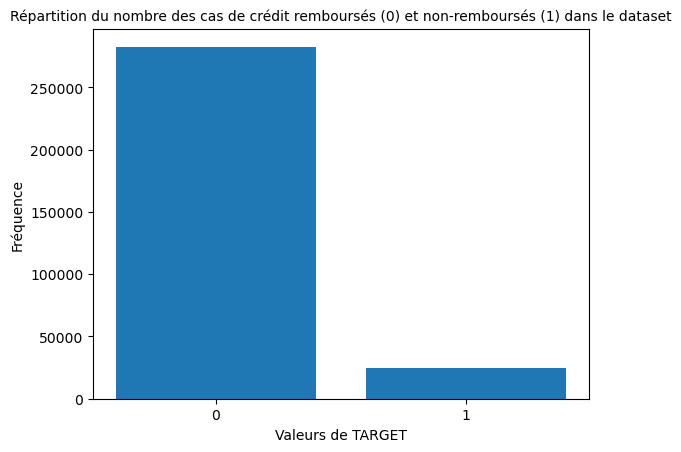

In [86]:
counts = app_train['TARGET'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(counts.index)
plt.xlabel('Valeurs de TARGET')  # Légende de l'axe des x
plt.ylabel('Fréquence')
plt.title('Répartition du nombre des cas de crédit remboursés (0) et non-remboursés (1) dans le dataset', fontsize = 10)
plt.show()

* **On peut déjà noté un grand déséquilibre dans la représentation des différents cas :**
    - ~92% des crédits accordés l'ont été à des "bons" clients
    - ~8% des crédits accordés l'ont été à des "mauvais" clients

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. 
* Lorsque nous testerons les futurs modèles, nous rééquilibrerons les classes dans les données afin de diminuer ce déséquilibre, et de permettre aux futurs modèles d'avoir plus de réprésentants de la classe '1' pour leur entrainement.

## VALEURS MANQUANTES

In [22]:
# taux global de valeurs manquantes 
taux_nan(app_train)

Le dataframe sélectionné contient 24.4 % de valeurs manquantes


In [71]:
# taux de valeurs manquantes par colonnes dans le train
df_nan_train = recap_nan(app_train)
df_nan_train

Le dataframe sélectionné a 122 colonnes et 307511 lignes.
* Il y a 55 colonnes sans aucune valeur manquante.
* Il y a 67 colonnes avec des valeurs manquantes.
* Parmi ces 67 colonnes, il y a 41 colonnes avec au moins 50% de valeurs manquantes.


,col_names,decompte_NaN,Taux_valeur_manquantes_%
0,DAYS_LAST_PHONE_CHANGE,1,0.000325
1,CNT_FAM_MEMBERS,2,0.000650
2,AMT_ANNUITY,12,0.003902
3,AMT_GOODS_PRICE,278,0.090403
4,EXT_SOURCE_2,660,0.214626
...,...,...,...
62,NONLIVINGAPARTMENTS_MODE,213514,69.432963
63,NONLIVINGAPARTMENTS_AVG,213514,69.432963
64,COMMONAREA_MODE,214865,69.872297
65,COMMONAREA_AVG,214865,69.872297


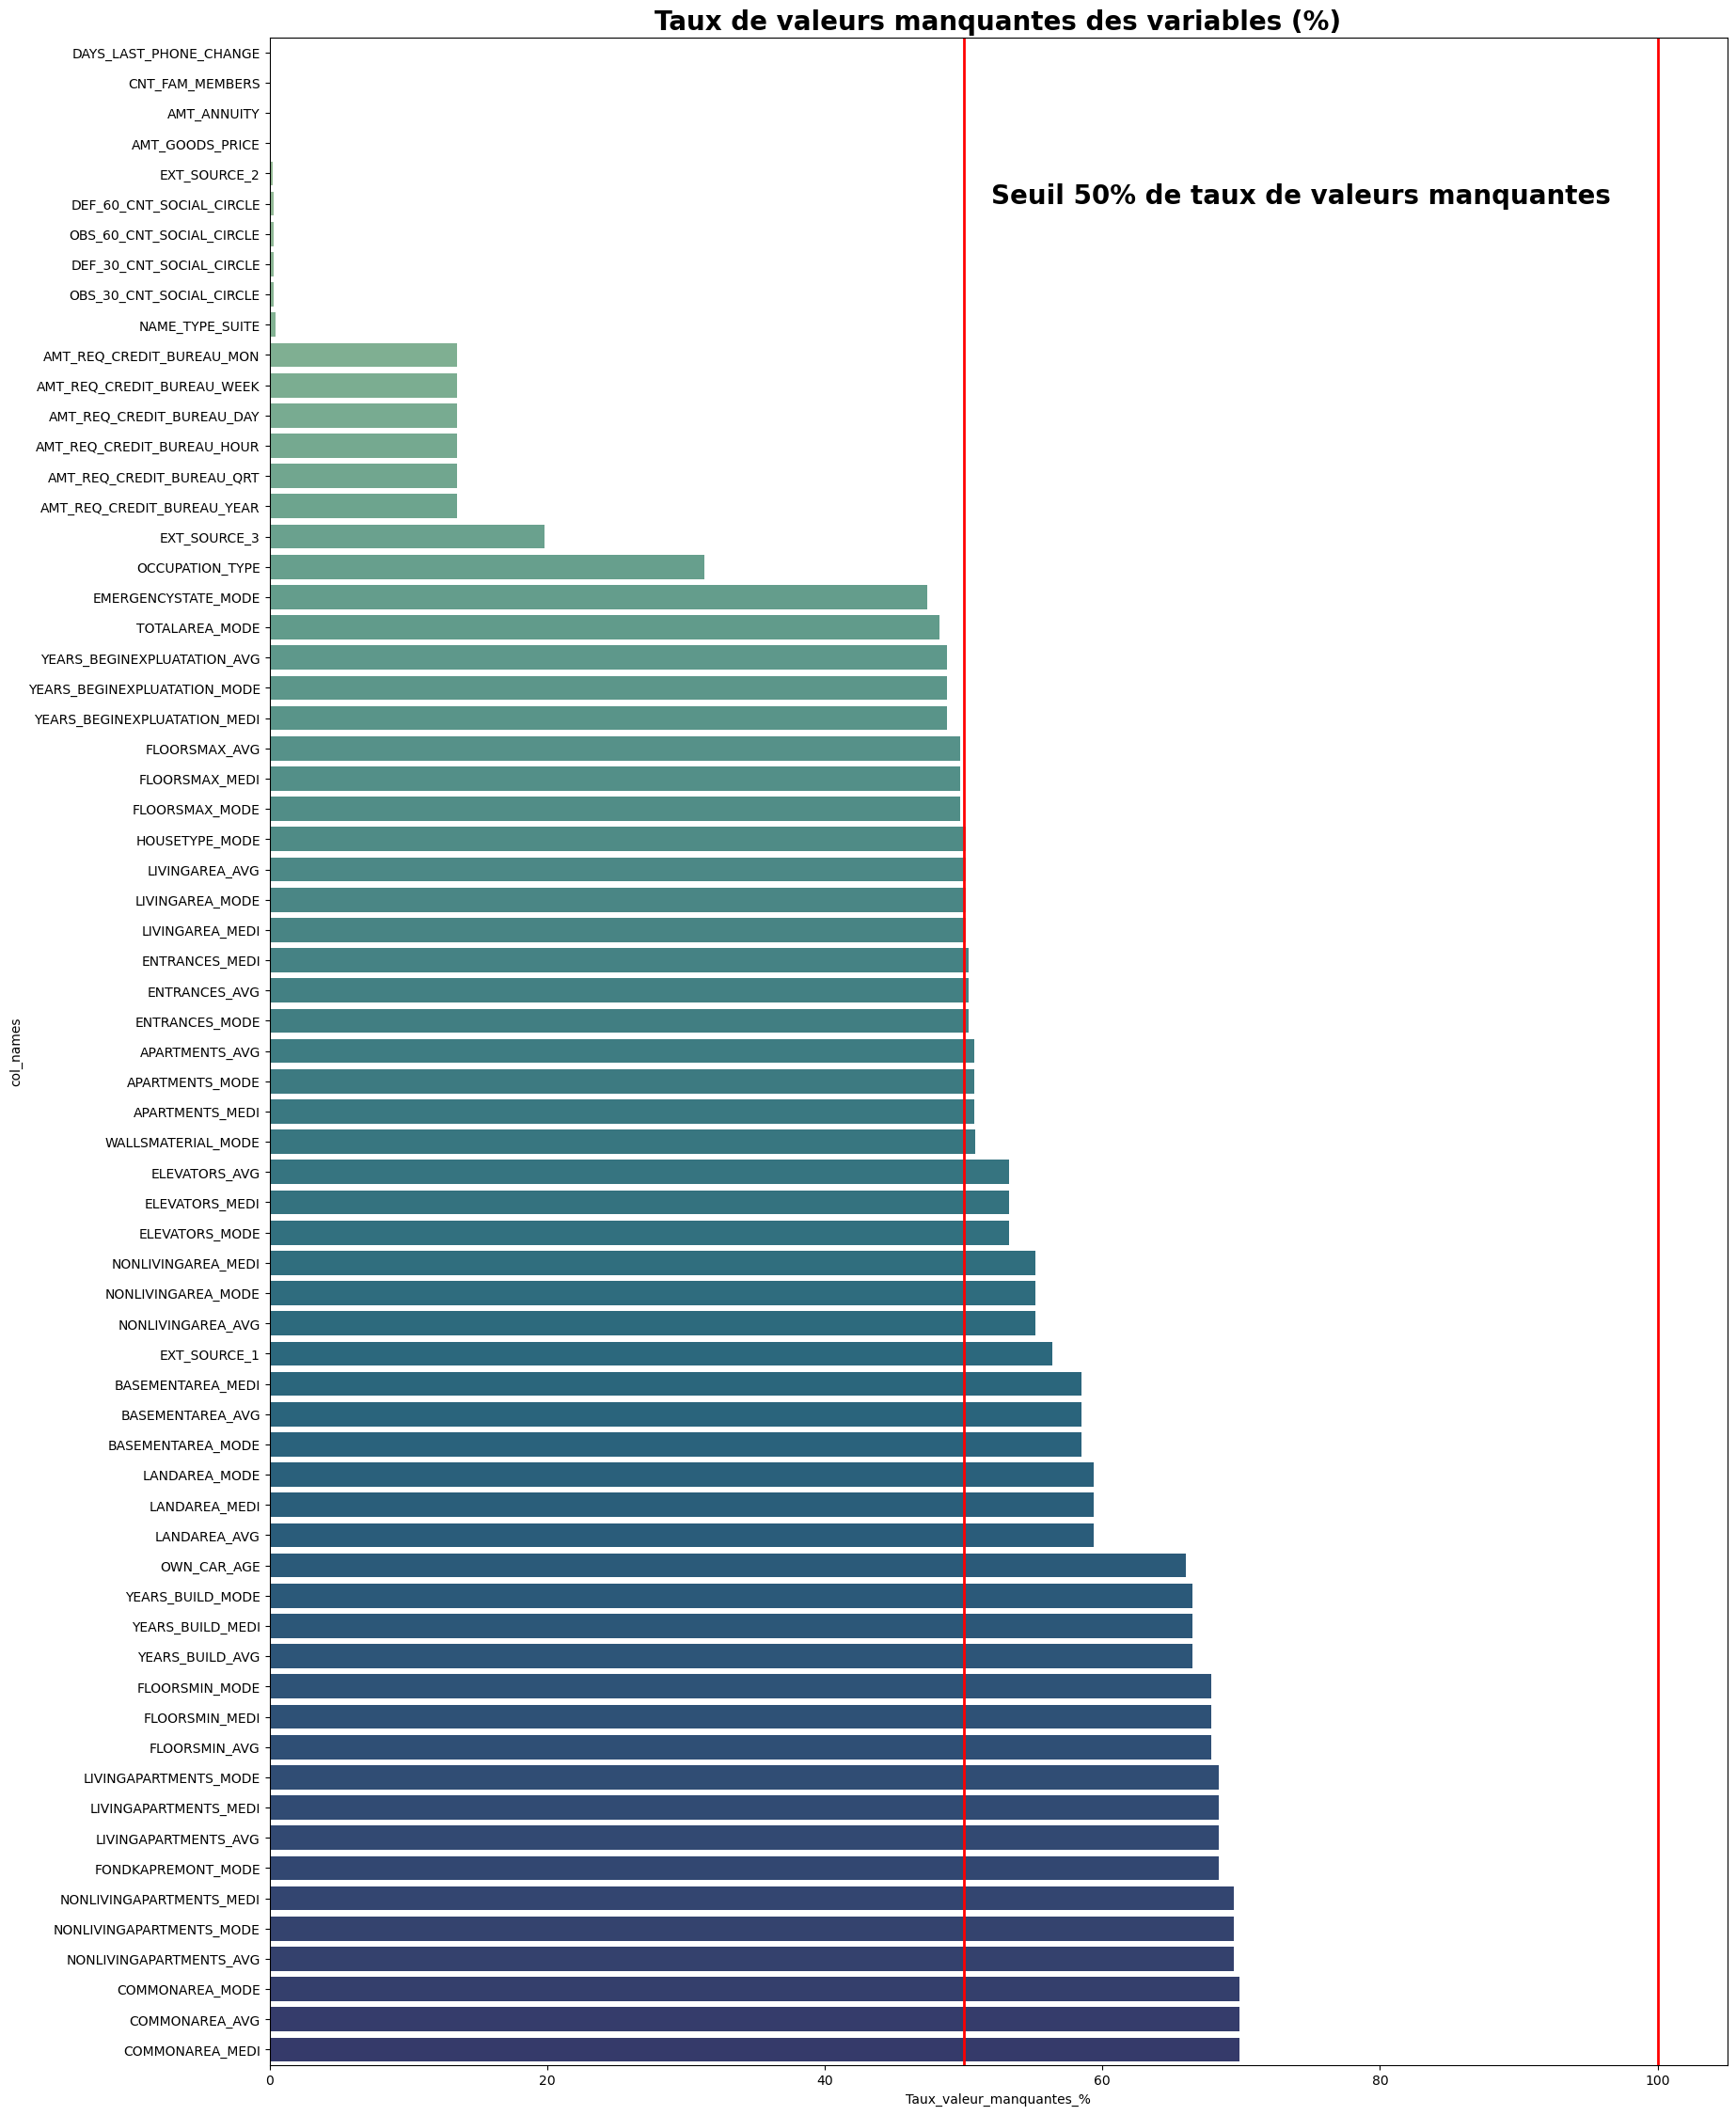

In [72]:
# graphique des taux de valeurs manquantes par colonnes dans le train 
graph_nan(df_nan_train)

* Pour nos futurs développements nous serons amenés à compléter les colonnes les valeurs manquantes, ou à les ignorer en les supprimant.
* Pour l'heure nous ne savons pas si ces colonnes seront utiles à notre futur modèle, nous les conservons donc pour l'instant.

## TYPES DE DONNÉES DANS CHAQUE COLONNES


In [73]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

### VARIABLES CATEGORIELLES

In [13]:
# nombre de valeur unique pour chaque variables catégorielles
print("Il y a " + str(app_train.dtypes.value_counts()[2]) + " variables catégorielles")
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

Il y a 16 variables catégorielles


NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

* la majorité des variables catégorielles possèdent un faible nombre de valeurs différentes.
* OCCUPATION_TYPE et ORGANIZATION_TYPE ont beaucoup de valeurs différentes possibles.

#### Choix de l'encodage des valeurs des colonnes catégorielles
* Afin d'éviter de produire un biais pour le modèle, nous éviterons le label-encoding pour les variables catégorielles comprenant PLUS DE 2 valeurs différentes, afin de ne pas attribuer de valeurs arbitraires aux différentes catégories.
* Nous préfererons le principe du "one-hot encoding" pour les variables catégorielles comprenant PLUS DE 2 valeurs différentes, ce qui créera une nouvelle colonne pour chaque catégorie unique issue d'une variable catégorielle. 
* Chaque observation recevra un "1" dans la colonne de la catégorie correspondante et un "0" dans toutes les autres nouvelles colonnes.


**Variables catégorielles à 2 valeurs possibles maximum**

In [88]:
# init le label encoder 
le = LabelEncoder()
le_count = 0

# pour chaque colonne, vérification du nombre de valeur et endocage des valeurs suivant le cas
for col in app_train:
    if app_train[col].dtype == 'object':
        # si 2 ou moins catégories différentes pour la feature
        if len(list(app_train[col].unique())) <= 2:
            # entrainement sur les données de train
            le.fit(app_train[col])
            # modification du train avec les features créées
            app_train[col] = le.transform(app_train[col])           
            # combien de colonnes ont été label-encodées
            le_count += 1
            
print('%d colonnes ont été label_encodées' % le_count)

3 colonnes ont été label_encodées


**Variables catégorielles à PLUS de 2 valeurs possibles**

In [89]:
# one-hot encoding pour les features catégorielles à plus de 2 valeurs possibles
app_train = pd.get_dummies(app_train)
print(app_train.shape)
app_train.head(2)

(307511, 243)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,True,False,False,False,False,False,False,True,False


In [90]:
# copie de travail
app_train_cat = app_train.copy(deep=True)
print(app_train_cat.shape)

(307511, 243)


### VARIABLES QUANTITATIVES

**Age des clients**

* L'âge des clients est calculable à partir de la colonne DAYS_BIRTH :
    - les chiffres négatifs de cette colonne indiquent le nombre de jours entre la naissance de l'emprunteur et la date de début du crédit
    - en mulitpliant par  -1 et en divisant par le nombre de jours dans une année, nous aurons l'âge de l'emprunteur


In [94]:
(app_train_cat['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

L'âge minimum (20ans) et l'âge maximum (69ans) des emprunteurs semblent cohérents.

Text(0.5, 1.0, "Répartition des clients par tranche d'âge de 5 ans")

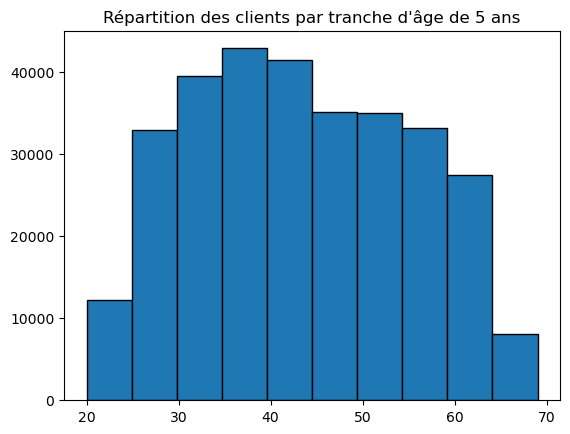

In [95]:
# répartition des âges des emprunteurs, par tranche de 5 ans
plt.hist((app_train_cat['DAYS_BIRTH'] / -365).astype(int), bins=10, edgecolor='black')
plt.title('Répartition des clients par tranche d\'âge de 5 ans')

**Nombre de jours en emploi**

"""DAYS_EMPLOYED How many days before the application the person started current employment,time only relative to the application"""
* la colonne DAYS_EMPLOYED calcule le nombre de jours entre le début de son emploi actuel et le moment de la demande de crédit
    - en mulitpliant par  -1 et en divisant par le nombre de jours dans une année, nous aurons le nombre d'année de travail de l'emprunteur

In [82]:
(app_train_cat['DAYS_EMPLOYED'] /-365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 1.0, "nombre d'années où l'emprunteur a travaillé avant la date de demande du crédit")

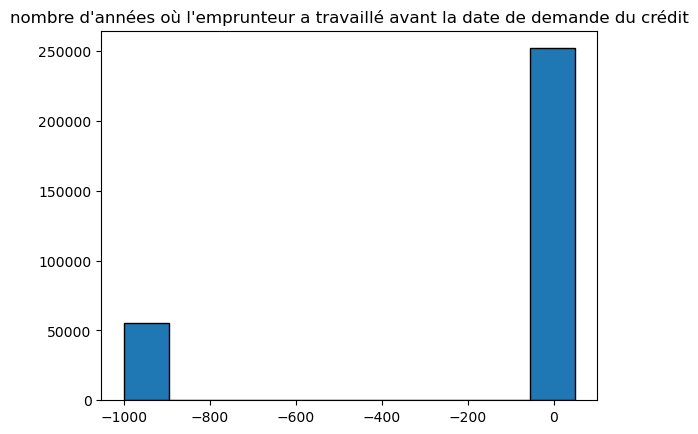

In [83]:
plt.hist((app_train_cat['DAYS_EMPLOYED'] / -365).astype(int), edgecolor='black')
plt.title('nombre d\'années où l\'emprunteur a travaillé avant la date de demande du crédit')

une valeur aberrantes apparait : -1000 ans d'emplois pour un emprunteur

au delà de la durée (1000ans), cela indiquerait suivant la logique de cette variable, que la personne "a travaillé ou plutot va travailler 1000ans après la demande du crédit".





In [84]:
# taux de défaut de paiement pour les clients avec cette anomalie 
anom = app_train_cat[app_train_cat['DAYS_EMPLOYED'] == 365243]
print("pourcentage des clients en anomalie sur DAYS_EMPLOYED en défaut de remboursement = ", round(anom['TARGET'].value_counts(normalize=True)[1] *100, 2) ,
      "\npourcentage des clients en anomalie sur DAYS_EMPLOYED en remboursement effectif = ", round(anom['TARGET'].value_counts(normalize=True)[0] *100, 2))
      

pourcentage des clients en anomalie sur DAYS_EMPLOYED en défaut de remboursement =  5.4 
pourcentage des clients en anomalie sur DAYS_EMPLOYED en remboursement effectif =  94.6


In [85]:
# taux de défaut de paiement pour les clients SANS cette anomalie 
non_anom = app_train_cat[app_train_cat['DAYS_EMPLOYED'] != 365243]
print("pourcentage des clients SANS anomalie sur DAYS_EMPLOYED en défaut de remboursement = ", round(non_anom['TARGET'].value_counts(normalize=True)[1] *100, 2) ,
      "\npourcentage des clients SANS anomalie sur DAYS_EMPLOYED en remboursement effectif = ", round(non_anom['TARGET'].value_counts(normalize=True)[0] *100, 2))

pourcentage des clients SANS anomalie sur DAYS_EMPLOYED en défaut de remboursement =  8.66 
pourcentage des clients SANS anomalie sur DAYS_EMPLOYED en remboursement effectif =  91.34


* il y a une différence notable de taux de défaut de paiement entre les emprunteurs avec cette anomalie et les autres. ils ont un taux bien plus faible de défaut de paiement.

* que signifie donc cette anomalie ? 
    - est-ce pour signifier que la personne est rentière jusqu'à son décès (retraite ou autre), ou qu'une assurance garantit le remboursement du prêt à la banque quoiqu'il arrive ?

* cette anomalie représente une part non négligeable du dataset (plus de 55.000 crédits)

* nous allons garder cette information, mais nous allons la modifier pour qu'elle n'agisse pas comme un outlier sur les données.

* nous allons changer la valeur en np.nan, afin de pouvoir imputer une nouvelle valeur plus tard le cas échéant

In [86]:
# créer une colonne marqueur de cette anomalie
app_train_cat['DAYS_EMPLOYED_ANOM'] = app_train_cat["DAYS_EMPLOYED"] == 365243

# dans la colonne DAYS_EMPLOYED remplacer la valeur par np.nan
app_train_cat['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train_cat['DAYS_EMPLOYED_ANOM'].value_counts()

DAYS_EMPLOYED_ANOM
False    252137
True      55374
Name: count, dtype: int64

Text(0.5, 1.0, "nombre d'années où l'emprunteur a travaillé avant la date de demande du crédit")

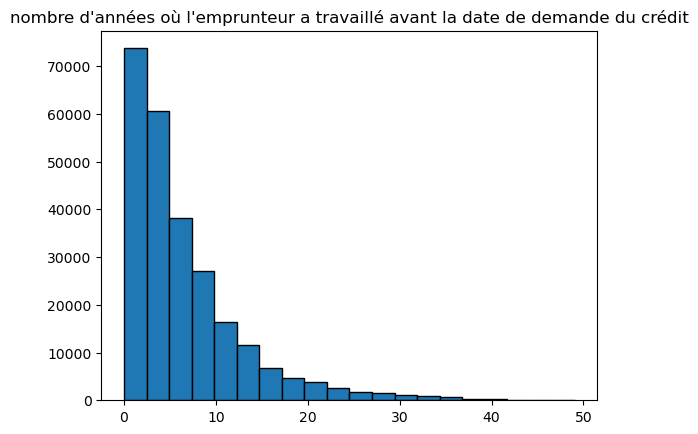

In [87]:
plt.hist((app_train_cat['DAYS_EMPLOYED'] / -365), edgecolor='black', bins = 20)
plt.title('nombre d\'années où l\'emprunteur a travaillé avant la date de demande du crédit')

* Grâce à nos traitements sur les valeurs aberrantes, nous obtenons une distribution des valeurs pour cette variable qui semble plus conforme à la réalité.
* L'information sur les anomalies n'est pas perdue (= colonne DAYS_EMPLOYED_ANOM)

## ÉTUDES DES CORRELATIONS DES VARIABLES AVEC LA CIBLE

* Avec le calcul du coefficient de corrélation de Pearson, nous allons vérifier la pertinence de chaque variable avec la cible
* nous pouvons le faire sur toutes les varibles puisque nous avons modifier la présentation des variables catgéorielles


In [88]:
# Find correlations with the target and sort
correlations = app_train_cat.corr()['TARGET'].sort_values()

# Display correlations
print('Les Corrélations positives les plus marquées :\n', correlations.tail(15))
print('\nLes Corrélations négatives les plus larquées :\n', correlations.head(15))

Les Corrélations positives les plus marquées :
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: f

* DAYS_BIRTH  est la variable la plus corrélée positive à la target, n'oublions pas que le calcul de DAYS_BIRTH est basé sur l'écart en nombre de jours entre la date de début du crédit et la naissance de l'emprunteur et est exprimée en jours négatifs.
* il faut comprendre donc que plus le client est agé, plus il a de chance de rembourser le crédit.
* nous allons donc utilisé pour l'analyse sur cette variable, la valeur absolue de DAYS_BIRTH.



### Effets de l'âge des clients sur le remboursement

In [89]:
# passage en valeur absolue de DAYS_BIRTH et calcul de la corrélation avec la target
app_train_cat['DAYS_BIRTH'] = abs(app_train_cat['DAYS_BIRTH'])
app_train_cat['DAYS_BIRTH'].corr(app_train_cat['TARGET'])

-0.07823930830982712

* Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps.
* la corrélation reste faible 

* reprenons le graphique précédent de répartition de l'âge des emprunteurs, en affinant les plages d'âges (de 10 bins à 25 bins)

Text(0, 0.5, 'Count')

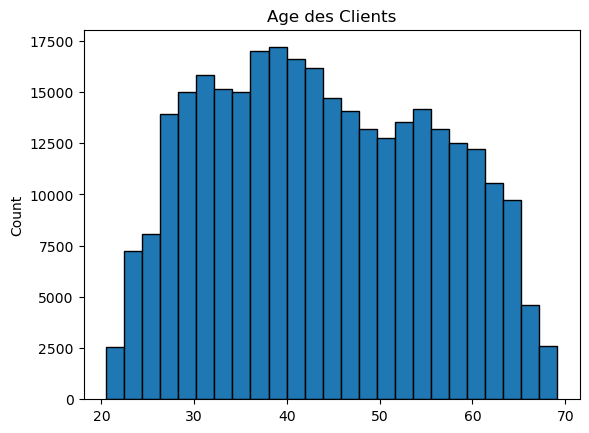

In [90]:
# répartition des âges des emprunteurs, par tranche de 2,5 ans
plt.hist((app_train_cat['DAYS_BIRTH'] / 365), bins=25, edgecolor='black')
plt.title('Age des Clients')
plt.ylabel('Count')

Nous allons observer l'effet de l'âge sur la target, en regardant la distribution de probabilté de l'âge sur la valeur de la target (ici 0 et 1)

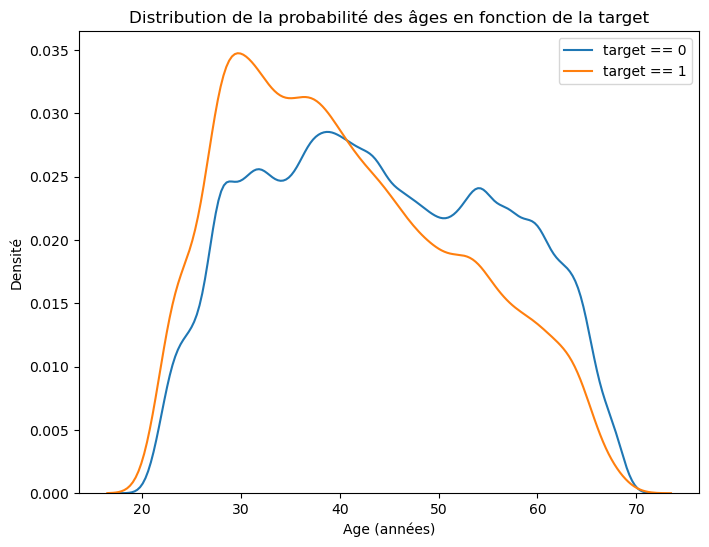

In [92]:
plt.figure(figsize = (8, 6))
sns.kdeplot(app_train_cat.loc[app_train_cat['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(app_train_cat.loc[app_train_cat['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution de la probabilité des âges en fonction de la target')
plt.legend()


* pour la target = 1 (non-remboursement), la probabilité d'être en défaut de paiement est plus grande lorsque le client a aux alentours des 30 ans, et décroit ensuite fortement et de manière continue
* pour la target = 0 (remboursement effectué), la probabilité de remboursement efefctif du crédit atteint son pic aux alentours de 40 ans, mais ne décroit pas fortement après et reste relativement stable
* malgré le coef de corr à -0,07, plutôt faible, et la distribution de la densité de l'âge par rapport à la target, nous pouvons quand même considérer que cette variable impacte la cible et sera doc utile à notre futur modèle
* pour aller plus loin, nous allons regarder le taux moyen de non-remboursement des prêts par tranches d'âges.
* nous allons discrétiser la variable âge en tranches d'âges de 5 ans, puis nous allons pour chaque tranche d'âge observer la moyenne de la target (le ratio de prêt non-remboursé pour chaque tranche d'âge)

In [93]:
age_data = app_train_cat[['TARGET', 'DAYS_BIRTH']]
age_data['AGE_ANNEE'] = age_data['DAYS_BIRTH'] / 365
age_data['TRANCHES_AGE'] = pd.cut(age_data['AGE_ANNEE'], bins = np.linspace(20, 70, num=11, dtype='int'))
age_data.head(10)

,TARGET,DAYS_BIRTH,AGE_ANNEE,TRANCHES_AGE
0,1,9461,25.920548,"(25, 30]"
1,0,16765,45.931507,"(45, 50]"
2,0,19046,52.180822,"(50, 55]"
3,0,19005,52.068493,"(50, 55]"
4,0,19932,54.608219,"(50, 55]"
5,0,16941,46.413699,"(45, 50]"
6,0,13778,37.747945,"(35, 40]"
7,0,18850,51.643836,"(50, 55]"
8,0,20099,55.065753,"(55, 60]"
9,0,14469,39.641096,"(35, 40]"


In [94]:
age_groups  = age_data.groupby('TRANCHES_AGE').mean()
age_groups

,TARGET,DAYS_BIRTH,AGE_ANNEE
TRANCHES_AGE,,,
"(20, 25]",0.123036,8532.795625,23.377522
"(25, 30]",0.111436,10155.219250,27.822518
"(30, 35]",0.102814,11854.848377,32.479037
"(35, 40]",0.089414,13707.908253,37.555913
"(40, 45]",0.078491,15497.661233,42.459346
"(45, 50]",0.074171,17323.900441,47.462741
"(50, 55]",0.066968,19196.494791,52.593136
"(55, 60]",0.055314,20984.262742,57.491131
"(60, 65]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, "RATIO DES PRÊTS NON-REMBOURSÉS PAR TRANCHES D'ÂGES")

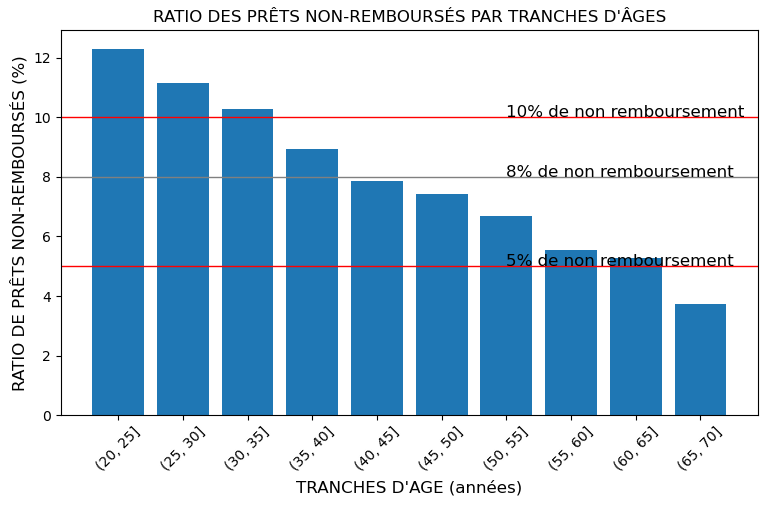

In [96]:
# REPRÉSENTATION GRAPHIQUE DU RATIO DE PRÊTS NON-REMBOURSÉS PAR TRANCHES D'ÂGES
font= {'color':  'black', 'size': 12 }
plt.figure(figsize = (9, 5))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 45)
plt.xlabel('TRANCHES D\'AGE (années)', fontdict= font)
plt.ylabel('RATIO DE PRÊTS NON-REMBOURSÉS (%)', fontdict= font)
plt.axhline(y=10, linewidth=1, color = 'r')
plt.axhline(y=5, linewidth=1, color = 'r')
plt.axhline(y=8, linewidth=1, color = 'grey')
plt.text(6, 10, "10% de non remboursement", fontdict= font)
plt.text(6, 5, "5% de non remboursement", fontdict= font)
plt.text(6, 8, "8% de non remboursement", fontdict= font)

plt.title('RATIO DES PRÊTS NON-REMBOURSÉS PAR TRANCHES D\'ÂGES', fontdict= font)


* le graphique confirme l'intuition première et la précise :
    - de 20 à 35 ans, le taux de non remboursement dépasse les 10%
    - à partir de 65 ans, le taux de non remboursement passe sous les 5%
* pour rappel la ratio de non remboursement global est de 8%
* la banque devra apporter une attention particulière à ces jeunes clients afin qu'ils puissent dimensionner au mieux leur capacité d'emprunt

### Effets des EXT_SOURCE sur la target
* les 3 variables avec les corrélations les plus fortes (en valeur absolue) sont les 3 EXT_SOURCE :

""" Normalized score from external data source,normalized """


In [97]:
ext_data = app_train_cat[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


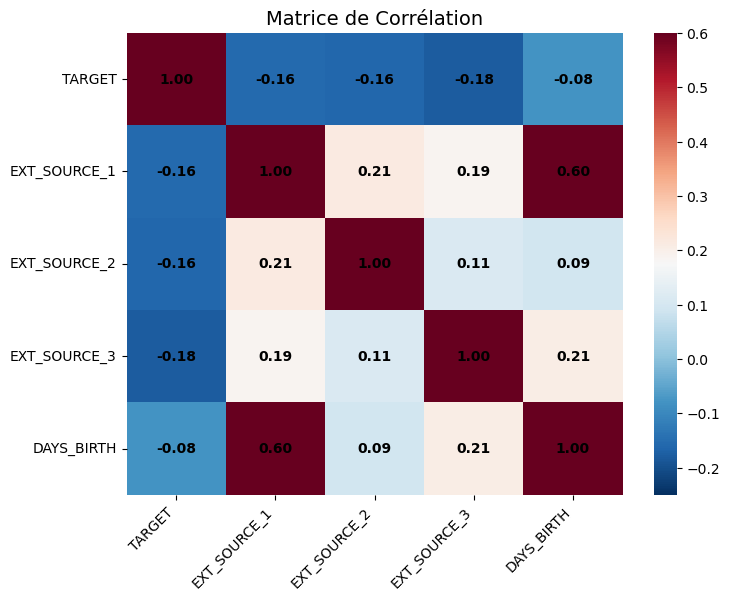

In [98]:
font= {'color':  'black', 'size': 10, 'weight': 'bold' }

plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, 
            #annot=True, 
            cmap='RdBu_r', fmt=".2f", vmin=-0.25, vmax=0.6, annot_kws={"size": 10})
for i in range(len(ext_data_corrs)):
    for j in range(len(ext_data_corrs.columns)):
        plt.text(j + 0.5, i + 0.5, f"{ext_data_corrs.iloc[i, j]:.2f}", ha='center', va='center', fontdict=font)
plt.xticks(rotation=45,  ha='right')
plt.title('Matrice de Corrélation', fontsize= 14)
plt.show()

* ces 3 variables sont toutes corrélées négativement avec la target, lorsqu'elles augmentent, le taux de non remboursement diminue

*  DAYS_BIRTH et EXT_SOURCE_1 sont également corrélées positivement entre elles, l'âge du client doit être pris en compte dans le calcul de cette avriable
* comme pour l'âge nous allons visualiser la distribution de chacune de ces 3 variables par rapport à la cible

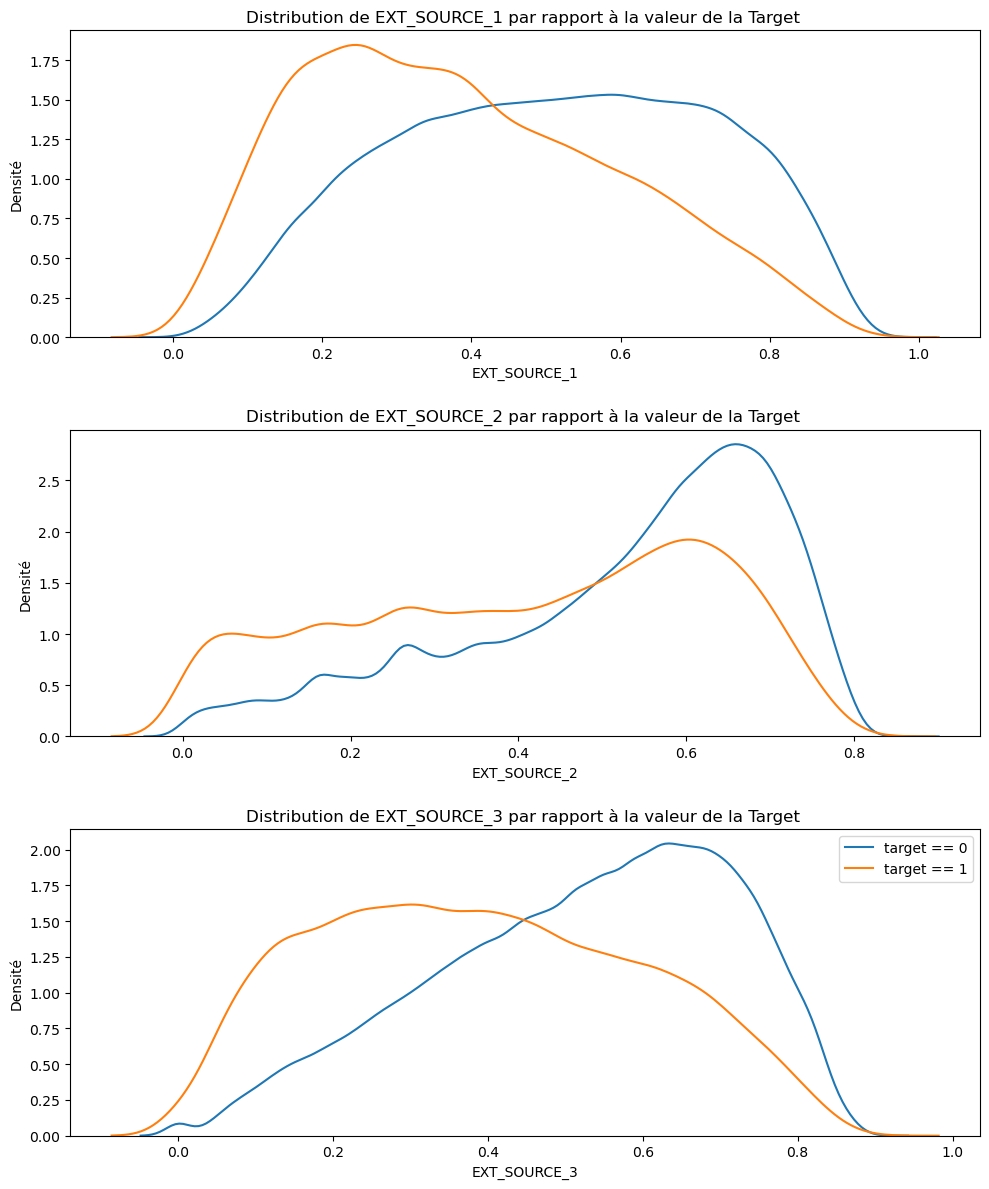

In [99]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train_cat.loc[app_train_cat['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train_cat.loc[app_train_cat['TARGET'] == 1, source], label = 'target == 1')
    plt.title('Distribution de %s par rapport à la valeur de la Target ' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité')
plt.tight_layout(h_pad = 2)
plt.legend()

* EXT_SOURCE_1 et EXT_SOURCE_3 ont chacune des distributions de valeurs assez différentes suivant la cible. il semble donc avoir une relation entre ces variables et la probabilité qu'un client soit en capacité de rembourser le prêt.
* elles devraient être utiles pour mettre au point le scoring demandé

# FEATURE ENGINEERING
* pour donner l'information la plus pertinente possible au futur modèle : 
    * créer de nouvelles caractéristiques à partir des existantes  (2 méthodes : des features polynomiales et features basées sur la connaissance/compréhension métier)
    * sélectionner les features les plus pertinentes pour réduire les dimensions de données 


## CRÉATION DE FEATURES POLYNOMIALES

In [100]:
poly_features = app_train_cat[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
# imputation des valeurs nulles par la médiane
imputer = SimpleImputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])
poly_features = imputer.fit_transform(poly_features)
# init du transformer pour créer des features polynomiales à 3 degrés (élévation de chaque feature sélectionnées à des puissances successives allant jusqu'à 3)
poly_transformer = PolynomialFeatures(degree = 3)

In [101]:
# ajustement du transformer polynomial sur les données
poly_transformer.fit(poly_features)
# transformation des features
poly_features = poly_transformer.transform(poly_features)
poly_features.shape

(307511, 35)

In [102]:
# créer un dataframe avec les features polynomiales et la target
poly_features_DF = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features_DF['TARGET'] = poly_target
poly_features_DF = poly_features_DF.drop('1', axis=1)
poly_features_DF

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,0.036649,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1
1,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,0.333073,...,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0
2,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,0.405575,...,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0
3,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,0.348166,...,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0
4,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,0.172754,...,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.145570,0.681632,0.535276,9327.0,0.021191,0.099226,0.077920,1357.735625,0.464623,0.364862,...,0.248701,4333.535804,0.195302,3403.064320,5.929720e+07,0.153368,2672.378236,4.656525e+07,8.113830e+11,0
307507,0.505998,0.115992,0.535276,20775.0,0.256034,0.058692,0.270849,10512.107006,0.013454,0.062088,...,0.007202,279.510194,0.033234,1289.874083,5.006225e+07,0.153368,5952.466801,2.310256e+08,8.966503e+12,0
307508,0.744026,0.535722,0.218859,14966.0,0.553575,0.398591,0.162837,11135.099105,0.286998,0.117248,...,0.062812,4295.209004,0.025661,1754.727146,1.199916e+08,0.010483,716.860892,4.902031e+07,3.352102e+12,0
307509,0.505998,0.514163,0.661024,11961.0,0.256034,0.260165,0.334477,6052.241247,0.264363,0.339874,...,0.174750,3162.050698,0.224665,4065.229651,7.355897e+07,0.288836,5226.384299,9.456968e+07,1.711207e+12,1


## CRÉATION DE FEATURES BASÉES SUR LA CONNAISANCE METIER
* CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport au revenu du client.
* ANNUITY_INCOME_PERCENT : le pourcentage de l'annuité du prêt par rapport au revenu du client.
* CREDIT_TERM : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
* DAYS_EMPLOYED_PERCENT : le pourcentage des jours d'emploi par rapport à l'âge du client.

In [104]:
df_train_domain = app_train_cat.copy()
df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']
df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']
df_train_domain.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,True,False,True,False,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,True,False,False,4.790750,0.132217,0.027598,-0.070862
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,4.222222,0.179963,0.042623,-0.152418


## AJOUTER LES NOUVELLES FEATURES AU DATAFRAME INITIAL

**NOTE À L'ATTENTION DE L'EXAMINATEUR**
* un problème apriori matériel non résolu encore, ni clairement identifié pour l'instant, fait planter le kernel au moment de réaliser un merge, et ce quelque soit le nombre de colonnes à merge entre elles.
* je contourne donc le problème en faisant une boucle sur les colonnes à rajouter issues du df des features polynomiales

In [106]:
data_domain_poly =  df_train_domain.drop(columns=['TARGET'], axis=1).copy(deep=True)
poly_list = poly_features_DF.columns
for col_name in poly_list :
    data_domain_poly[col_name] = poly_features_DF[col_name] 
data_domain_poly.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0


* dans le but d'améliorer les performances d'apprentissage des futurs modèles en terme de coût, nous allons réduire les dimensions du nouveau dataset en supprimant des features
* pour la suppression des features, nous allons sélectionner celles dont la corrélation à la target est supérieure à la médiane des corrélations de toutes les features à la target (en valeur absolue pour ne pas perdre les features corrélées négativement à la target)
* ainsi nous maximisons l'information des features apportées au modèle, tout en réduisant les ressources nécessaires à l'apprentissage du futur modèle

In [107]:
# calculer les corrélations de chaque features à la target
data_domain_poly_corrs = data_domain_poly.corr()['TARGET'].sort_values()

In [108]:
# création du dataframe avec les features qui seront améliorer pour les futurs modèles
final_features_df = data_domain_poly[data_domain_poly_corrs[abs(data_domain_poly_corrs.values) >= abs(data_domain_poly_corrs).median()].index]
final_features_df

,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2^2,...,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER_M,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_EMPLOYED_PERCENT,DAYS_EMPLOYED,TARGET
0,0.036649,0.003043,346.733022,0.009637,0.005108,0.021834,0.011573,0.262949,2487.756636,0.005741,...,0,-2120,True,-1134.0,True,2,2,-0.067329,-637.0,1
1,0.333073,0.103675,5583.975307,0.207254,0.178286,0.193685,0.166614,0.622246,10431.950422,0.120520,...,0,-291,False,-828.0,False,1,1,-0.070862,-1188.0,0
2,0.405575,0.205220,7724.580288,0.225464,0.295894,0.281290,0.369159,0.555912,10587.901540,0.156373,...,0,-2531,True,-815.0,True,2,2,-0.011814,-225.0,0
3,0.348166,0.176171,6616.894625,0.226462,0.186365,0.329122,0.270849,0.650442,12361.644326,0.214075,...,0,-2437,False,-617.0,True,2,2,-0.159905,-3039.0,0
4,0.172754,0.087413,3443.335521,0.055754,0.092471,0.163305,0.270849,0.322738,6432.819536,0.052705,...,1,-3458,True,-1106.0,True,2,2,-0.152418,-3038.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.364862,0.053113,3403.064320,0.248701,0.195302,0.099226,0.077920,0.681632,6357.585111,0.067635,...,0,-1982,True,-273.0,True,1,1,-0.025303,-236.0,0
307507,0.062088,0.031416,1289.874083,0.007202,0.033234,0.058692,0.270849,0.115992,2409.735313,0.006808,...,0,-4090,False,0.0,False,2,2,NaN,NaN,0
307508,0.117248,0.087235,1754.727146,0.062812,0.025661,0.398591,0.162837,0.535722,8017.611736,0.213534,...,1,-5150,False,-1909.0,True,3,3,-0.529266,-7921.0,0
307509,0.339874,0.171975,4065.229651,0.174750,0.224665,0.260165,0.334477,0.514163,6149.901495,0.133767,...,1,-931,False,-322.0,False,2,2,-0.400134,-4786.0,1


## PRÉPARATION DES DONNÉES FINALES
* Observons les NAN dans notre dataset final

In [109]:
df_nan_data = recap_nan(final_features_df)
df_nan_data

Le dataframe sélectionné a 139 colonnes et 307511 lignes.
* Il y a 93 colonnes sans aucune valeur manquante.
* Il y a 46 colonnes avec des valeurs manquantes.
* Parmi ces 46 colonnes, il y a 31 colonnes avec au moins 50% de valeurs manquantes.


,col_names,decompte_NaN,Taux_valeur_manquantes_%
0,DAYS_LAST_PHONE_CHANGE,1,0.000325
1,ANNUITY_INCOME_PERCENT,12,0.003902
2,CREDIT_TERM,12,0.003902
3,AMT_ANNUITY,12,0.003902
4,AMT_GOODS_PRICE,278,0.090403
5,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.332021
6,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.332021
7,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
8,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
9,DAYS_EMPLOYED,55374,18.007161


### IMPUTATION PAR LA MÉDIANE DES VALEURS NULLES

In [113]:
data_imput = final_features_df.copy(deep=True)

In [114]:
for col_name in data_imput.columns[:-1] :
    data_imput.loc[data_imput[col_name].isnull(), col_name] = data_imput[col_name].median()
data_imput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 139 entries, EXT_SOURCE_2 EXT_SOURCE_3 to TARGET
dtypes: float64(83), int64(18), object(38)
memory usage: 326.1+ MB


In [116]:
# vérification de l'imputation des valeurs nulles
df_nan_train = recap_nan(data_imput)
df_nan_train

Le dataframe sélectionné a 139 colonnes et 307511 lignes.
* Il n'y a aucune colonne contenant des valeurs manquantes.


## ENREGISTREMENT DU DATASET FINAL
* notre dataset final est prêt à être utiliser pour l'entrainement des futurs modèles.
* nous le sauvegardons pour nos futurs travaux.

In [117]:
data_imput.to_csv('final_data.csv', index = False)